<a href="https://colab.research.google.com/github/duper203/upstage_cookbook/blob/main/from_togetherai/embedding_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizing Movie Dataset Embeddings

In this notebook, we will be embedding a subset of the Movies Dataset and visualizing the generated vector space representations of the movies using a technique called Uniform Manifold Approximation and Projection (UMAP).


We will color code the movies using genres and see if similar movie genres cluster together in vector space and apart from movies of different movie genres.




In [ ]:
pip install -qU langchain-upstage umap-learn[plot]

In [4]:
import os
from google.colab import userdata
os.environ["UPSTAGE_API_KEY"] = userdata.get("UPSTAGE_API_KEY")

## Download and View the Dataset

In [2]:
# Let's get the movies dataset
!wget https://raw.githubusercontent.com/togethercomputer/together-cookbook/refs/heads/main/datasets/movies.json
!mkdir datasets
!mv movies.json datasets/movies.json

--2024-10-23 18:37:36--  https://raw.githubusercontent.com/togethercomputer/together-cookbook/refs/heads/main/datasets/movies.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 461845 (451K) [text/plain]
Saving to: ‘movies.json’

movies.json         100%[===================>] 451.02K  --.-KB/s    in 0.05s   

2024-10-23 18:37:37 (9.29 MB/s) - ‘movies.json’ saved [461845/461845]



In [3]:
import json

with open('./datasets/movies.json', 'r') as file:
    movies_data = json.load(file)

movies_data[:3]

[{'title': 'Minions',
  'overview': 'Minions Stuart, Kevin and Bob are recruited by Scarlet Overkill, a super-villain who, alongside her inventor husband Herb, hatches a plot to take over the world.',
  'director': 'Kyle Balda',
  'genres': 'Family Animation Adventure Comedy',
  'tagline': 'Before Gru, they had a history of bad bosses'},
 {'title': 'Interstellar',
  'overview': 'Interstellar chronicles the adventures of a group of explorers who make use of a newly discovered wormhole to surpass the limitations on human space travel and conquer the vast distances involved in an interstellar voyage.',
  'director': 'Christopher Nolan',
  'genres': 'Adventure Drama Science Fiction',
  'tagline': 'Mankind was born on Earth. It was never meant to die here.'},
 {'title': 'Deadpool',
  'overview': 'Deadpool tells the origin story of former Special Forces operative turned mercenary Wade Wilson, who after being subjected to a rogue experiment that leaves him with accelerated healing powers, ado

## Generate Embeddings


In [9]:
from typing import List
import numpy as np
from langchain_upstage import UpstageEmbeddings


def generate_embeddings(input_texts: List[str]) -> List[List[float]]:
    """Generate embeddings from Together python library.

    Args:
        input_texts: a list of string input texts.
        model_api_string: str. An API string for a specific embedding model of your choice.

    Returns:
        embeddings_list: a list of embeddings. Each element corresponds to the each input text.
    """
    embeddings = UpstageEmbeddings(model="solar-embedding-1-large")
    embed_list = embeddings.embed_documents(input_texts)
    # together_client = together.Together(api_key = TOGETHER_API_KEY)
    # outputs = together_client.embeddings.create(
    #     input=input_texts,
    #     model=model_api_string,
    # )
    return embed_list

In [5]:
# Concatenate the title, overview, and tagline of each movie
# this makes the text that will be embedded for each movie more informative
# as a result the embeddings will be richer and capture this information.
to_embed = []
for movie in movies_data[:1000]:
    text = ''
    for field in ['title', 'overview', 'tagline']:
        value = movie.get(field, '')
        text += str(value) + ' '
    to_embed.append(text.strip())

to_embed[:10]

['Minions Minions Stuart, Kevin and Bob are recruited by Scarlet Overkill, a super-villain who, alongside her inventor husband Herb, hatches a plot to take over the world. Before Gru, they had a history of bad bosses',
 'Interstellar Interstellar chronicles the adventures of a group of explorers who make use of a newly discovered wormhole to surpass the limitations on human space travel and conquer the vast distances involved in an interstellar voyage. Mankind was born on Earth. It was never meant to die here.',
 'Deadpool Deadpool tells the origin story of former Special Forces operative turned mercenary Wade Wilson, who after being subjected to a rogue experiment that leaves him with accelerated healing powers, adopts the alter ego Deadpool. Armed with his new abilities and a dark, twisted sense of humor, Deadpool hunts down the man who nearly destroyed his life. Witness the beginning of a happy ending',
 'Guardians of the Galaxy Light years from Earth, 26 years after being abducted,

In [10]:
from langchain_upstage import UpstageEmbeddings

embeddings = generate_embeddings(to_embed)

In [13]:
len(embeddings)

1000

In [14]:
embeddings_np = np.array(embeddings)

embeddings_np.shape

(1000, 4096)

In [15]:
# Extract the genres and titles for each movie
genres = [movie['genres'].split()[0] for movie in movies_data]
titles = [movie['title'] for movie in movies_data]
set(genres)

{'Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science',
 'Thriller',
 'War',
 'Western'}

## Visualize Embeddings using UMAP

UMAP is a technique that uses local structure of the high dimensional vectors to reduce them down to a very low dimensional space. In our case below we will be projecting each 4096 dimensional vector down to 2 dimensions and then visualizing it.

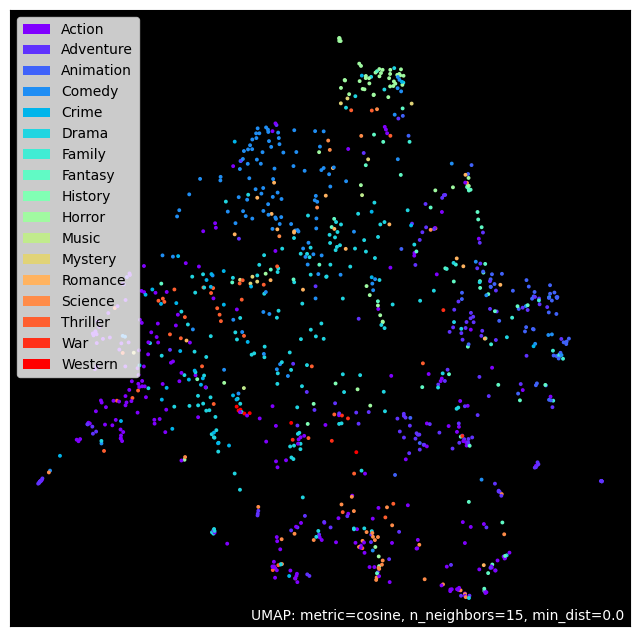

In [18]:
import umap, umap.plot
import matplotlib.pyplot as plt

# UMAP with cosine metric - this is because the embeddings model is trained using cosine similarity
mapper = umap.UMAP(n_neighbors=15, min_dist=0.0, metric='cosine', random_state=42).fit(embeddings)

# Plot the 2d UMAP embeddings and color by genre
umap.plot.points(mapper, labels = np.array(genres), theme='fire');

Here we can see that there is some clustering with respect to the movie genres, however there is not a clear pattern - this is probably because the genres for each movie can overlap and each movie actually has multiple genres.